In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import pickle
plt.rcParams['figure.dpi']= 200

import torch
from torch import optim, nn
from torch.autograd import Variable

In [2]:
task_stim=pd.read_excel('contstim_pilot_n11_spreadsheet.xlsx')
task_data=pd.read_csv('data_exp_22452-v9_task-ax2v.csv')

In [214]:
models=['bigram','trigram','rnn','lstm','bilstm','bert','bert_whole_word','roberta','xlm','electra','gpt2']

prob_dict=dict()
for model_name in models:
    f = open(model_name+'_expt1_sentence_probs.pkl','rb')
    dict1=pickle.load(f)
    prob_dict.update(dict1)
    
    
events=list(task_data['Event Index'])
start_inds=[i for i,e in enumerate(events) if e=='1']

fitsets=[]

for i,start_ind in enumerate(start_inds):

    setnum=task_data['counterbalance-o1ql'][start_ind]

    if i==12:
        setnum='set 12'

    sub=task_data['Participant External Session ID'][start_ind]

    model1_list=list(task_stim['sentence1_model_'+setnum])[1:]
    model2_list=list(task_stim['sentence2_model_'+setnum])[1:]
    sent1_list=list(task_stim['sentence1_'+setnum])[1:]
    sent2_list=list(task_stim['sentence2_'+setnum])[1:]

    if setnum=='set 1':
        source_list=list(task_stim['source'])[1:]

    else:
        source_list=list(task_stim['source_'+setnum])[1:]

    if i<len(start_inds)-1:
        responses_list=list(task_data['Response'][start_ind:start_inds[i+1]])

    else:
        responses_list=list(task_data['Response'][start_ind:])

    responses_list=[r for r in responses_list if str(r)!='nan']

    item_ids=[]

    fitset=[]
    
    for t in range(110):

        source=source_list[t]

        model1=model1_list[t]
        model2=model2_list[t]
        sent1=sent1_list[t]
        sent2=sent2_list[t]

        model1_name=model1[:-2]
        model2_name=model2[:-2]        

        model_ind=models.index(model1_name)

        sents=[sent1,sent2]
        sents.sort()
        item_id='_'.join(sents)
        
        if item_id in item_ids:
            continue
        
        item_ids.append(item_id)

        response=responses_list[t]

        response_ind=[sent1,sent2].index(response)      

        log_p1=prob_dict[sent1]
        log_p2=prob_dict[sent2]

        #if source=='generator':
            
        fitset.append([model1_name,log_p1,log_p2,response_ind])
        
    fitsets.append(fitset)

fitsets_all=[]
for fitset in fitsets:
    fitsets_all+=fitset


In [222]:
minps=[]
for m in models:
    m=np.min([np.min([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    minps.append(m)
    
minps=np.abs(minps)


maxps=[]
for m in models:
    m=np.max([np.max([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    maxps.append(m)
    
maxps=np.abs(maxps)


In [142]:
gamma_boots=[]

for boot in range(50):
    
    boots=np.random.choice(13, 13)
    
    fitset=[]
    for b in boots:
        fitset+=fitsets[b]
    
    squashes=Variable(torch.tensor(minps).to('cuda'), requires_grad = True)
    gamma=Variable(torch.tensor(10.).to('cuda'), requires_grad = True)

    opt = optim.Adam([squashes,gamma],lr=1)

    print(boot)
    print('')

    for epoch in range(200):

        loss = Variable(torch.tensor(0.).to('cuda'), requires_grad = True)   

        for trial in fitset:

            model1_name=trial[0]

            log_p1=torch.tensor(trial[1]).to('cuda')
            log_p2=torch.tensor(trial[2]).to('cuda')

            response_ind=trial[3]

            squash_threshold=squashes[models.index(model1_name)]

            width=1

            log_p1_corrected=width*torch.log(1+math.e**((log_p1+squash_threshold)/width))-squash_threshold
            log_p2_corrected=width*torch.log(1+math.e**((log_p2+squash_threshold)/width))-squash_threshold

            s1a_b = log_p1_corrected - log_p2_corrected

            p1=1/(1+torch.exp(-(s1a_b)/gamma))
            p2=1-p1

            log_p_choice=-torch.log([p1,p2][response_ind])

            loss=loss+log_p_choice


        if epoch%90==0:
            print(loss)
            print(squashes)
            print(gammas)
            print('')

        loss.backward()

        opt.step()
        opt.zero_grad()
        
    squashes=squashes.detach().cpu().numpy()
    gamma=float(gamma)

    gamma_boots.append(gamma)
    
    if boot==0:
        squash_boots=squashes
    else:
        squash_boots=np.concatenate((squash_boots,squashes),axis=0)


0

tensor(1320.5369, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([166.9858, 153.9043, 138.1582, 139.9895, 119.7223, 124.2057, 122.7220,
        130.9030, 119.5330, 111.7632, 113.3122], device='cuda:0',
       dtype=torch.float64, requires_grad=True)
tensor([28.2555, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)

tensor(831.5382, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([136.1375, 130.7872,  86.7039, 127.2884, 123.8768, 109.6497,  84.8141,
        118.7596,  97.4124,  62.8551,  79.6438], device='cuda:0',
       dtype=torch.float64, requires_grad=True)
tensor([28.2555, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)

tensor(831.3024, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([136.6031, 130.6315,  88.2857, 127.1014, 124.6718, 110.4878,

KeyboardInterrupt: 

In [ ]:
#synthetic

# tensor(671.4779, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.5626, 128.7844,  84.1193,  92.4041, 111.8108, 105.3416,  83.8154,
#         116.5818,  87.0363,  60.6492,  81.0560], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([29.8585, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


#natural

# tensor(148.7837, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([115.8415,  84.2844,  72.0876,  43.8699,  54.9998,  50.4821,  69.6983,
#          49.1065,  42.4528,  34.6840,  59.5816], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([ 9.1418, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


# tensor(829.6835, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.1968, 127.7177,  83.4297,  91.0015, 111.4391, 104.3089,  83.3092,
#         115.3282,  85.6379,  59.8025,  79.7266], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([28.2664, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


In [206]:
squash_boots=np.array([[136.6031, 130.6315,  88.2857, 127.1014, 124.6718, 110.4878,  84.6417,
        118.1435, 107.7737,  63.0790,  79.9143],
              [137.9003, 125.7105,  84.5635, 127.1772, 112.0871,  94.5774,  78.6344,
        114.0863,  95.4273,  58.2541,  79.6323],
              [131.8761, 133.7181, 147.7142, 143.2530, 110.6293, 134.2203,  83.7578,
        139.0220,  82.7407,  66.7261,  79.2919],
              [139.6443, 135.6945,  80.5810,  94.8058, 116.6113, 103.0531,  87.4392,
        119.7775,  81.2322,  60.9193,  81.1773],
              [132.4967, 128.7608,  92.4549,  91.8489, 110.4346, 104.1544,  80.5317,
        126.0785, 124.9601,  57.4880,  76.9285],
              [128.2988, 112.9426,  80.0811,  90.9844, 111.0652, 115.8396,  56.3730,
         78.9889, 120.2621,  29.6331,  61.9582],
              [127.7181, 132.9688, 148.8201,  94.7272, 109.7225,  87.5404,  81.3132,
        115.8013, 116.9241,  64.7583,  73.5550],
              [120.8540, 116.8421, 135.4461,  88.5892, 124.1079, 133.7935,  86.1704,
        100.1683,  92.7386,  49.7565,  79.4477],
              [125.4391, 114.5180,  82.5459,  87.4416, 110.8198,  93.8739,  63.4568,
        117.9814,  83.9064,  57.2624,  77.2107],
              [129.6447, 129.3590,  86.6444,  92.5276, 109.5141, 105.0256,  65.8152,
        117.5682, 125.8277,  59.4612,  77.8789]])


squash_boots=squash_boots.T
squash_boots.sort()
squash_boots=squash_boots.T

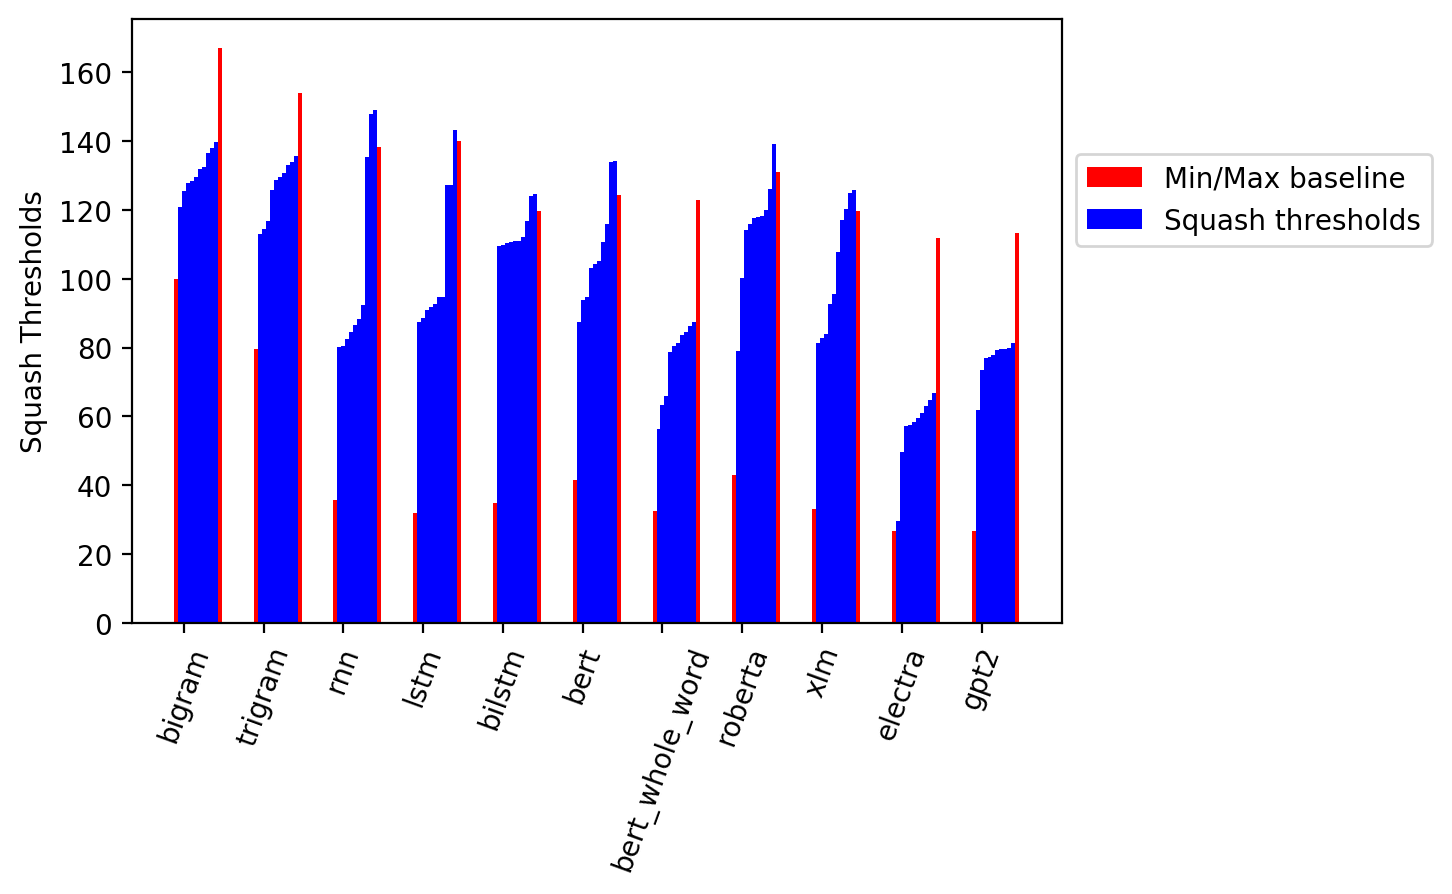

In [224]:
#squash_boots=squash_boots.reshape([10,11])



x=np.arange(11)*2
plt.bar(x-0.2, maxps, width=0.1, color=[1,0,0])
plt.bar(x-0.1, squash_boots[0], width=0.1, color=[0,0,1])
plt.bar(x, squash_boots[1], width=0.1, color=[0,0,1])
plt.bar(x+0.1, squash_boots[2], width=0.1, color=[0,0,1])
plt.bar(x+0.2, squash_boots[3], width=0.1, color=[0,0,1])
plt.bar(x+0.3, squash_boots[4], width=0.1, color=[0,0,1])
plt.bar(x+0.4, squash_boots[5], width=0.1, color=[0,0,1])
plt.bar(x+0.5, squash_boots[6], width=0.1, color=[0,0,1])
plt.bar(x+0.6, squash_boots[7], width=0.1, color=[0,0,1])
plt.bar(x+0.7, squash_boots[8], width=0.1, color=[0,0,1])
plt.bar(x+0.8, squash_boots[9], width=0.1, color=[0,0,1])
plt.bar(x+0.9, minps, width=0.1, color=[1,0,0])

plt.ylabel('Squash Thresholds')
plt.xticks(x,models,rotation=70)

legs=['Min/Max baseline','Squash thresholds']
plt.legend(legs,bbox_to_anchor=(1, 0.3, 0.2, 0.5))

In [ ]:
len(fitset)

[109, 104, 109, 103, 101, 103, 107, 105, 106, 103, 102, 105, 103]

In [173]:
d=squash_boots.T

In [170]:

d=np.array([f.sort() for f in d])

In [171]:
d

array([None, None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [180]:
squash_boots=d.T